In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd
import copy

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/linalg/__init__.py:202: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/optimize/_trlib/__init__.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._trlib import TRLIBQuadraticSubproblem
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate bi

In [2]:
import smart
import coronagraph as cg
from jakely.plot import ColorTable

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _bspl
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:94: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .ckdtree import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .qhull import *
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/_spherical_voronoi.py:18: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _voronoi
/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/spatial/distance.py:121: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, go

In [3]:
sys.path.insert(1, "../scripts")

import spectroscopy

In [4]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

In [5]:
# Create LUVOIR DRM
drmx = spectroscopy.HEC_DRM(
    wantSNR = 8.5, 
    wantexp = 365., 
    Ahr_flat = 0.20,
    eta_int = 0.1, 
    #bandwidth = 0.1, 
    bandwidth = [0.2, 0.2, 0.1],     # Using channel dependent bandwidth
    architecture = "A", 
    telescope_mods = {}
)

In [6]:
# Calculate table of exposure times
drmx.generate_exptime_table()

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:290: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:291: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt
../scripts/spectroscopy.py:1289: RuntimeWarning: divide by zero encountered in double_scalars
  t_snr = (wantsnr**2 - intercept) / slope
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:287: RuntimeWarning: invalid value encountered in multiply
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * 

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


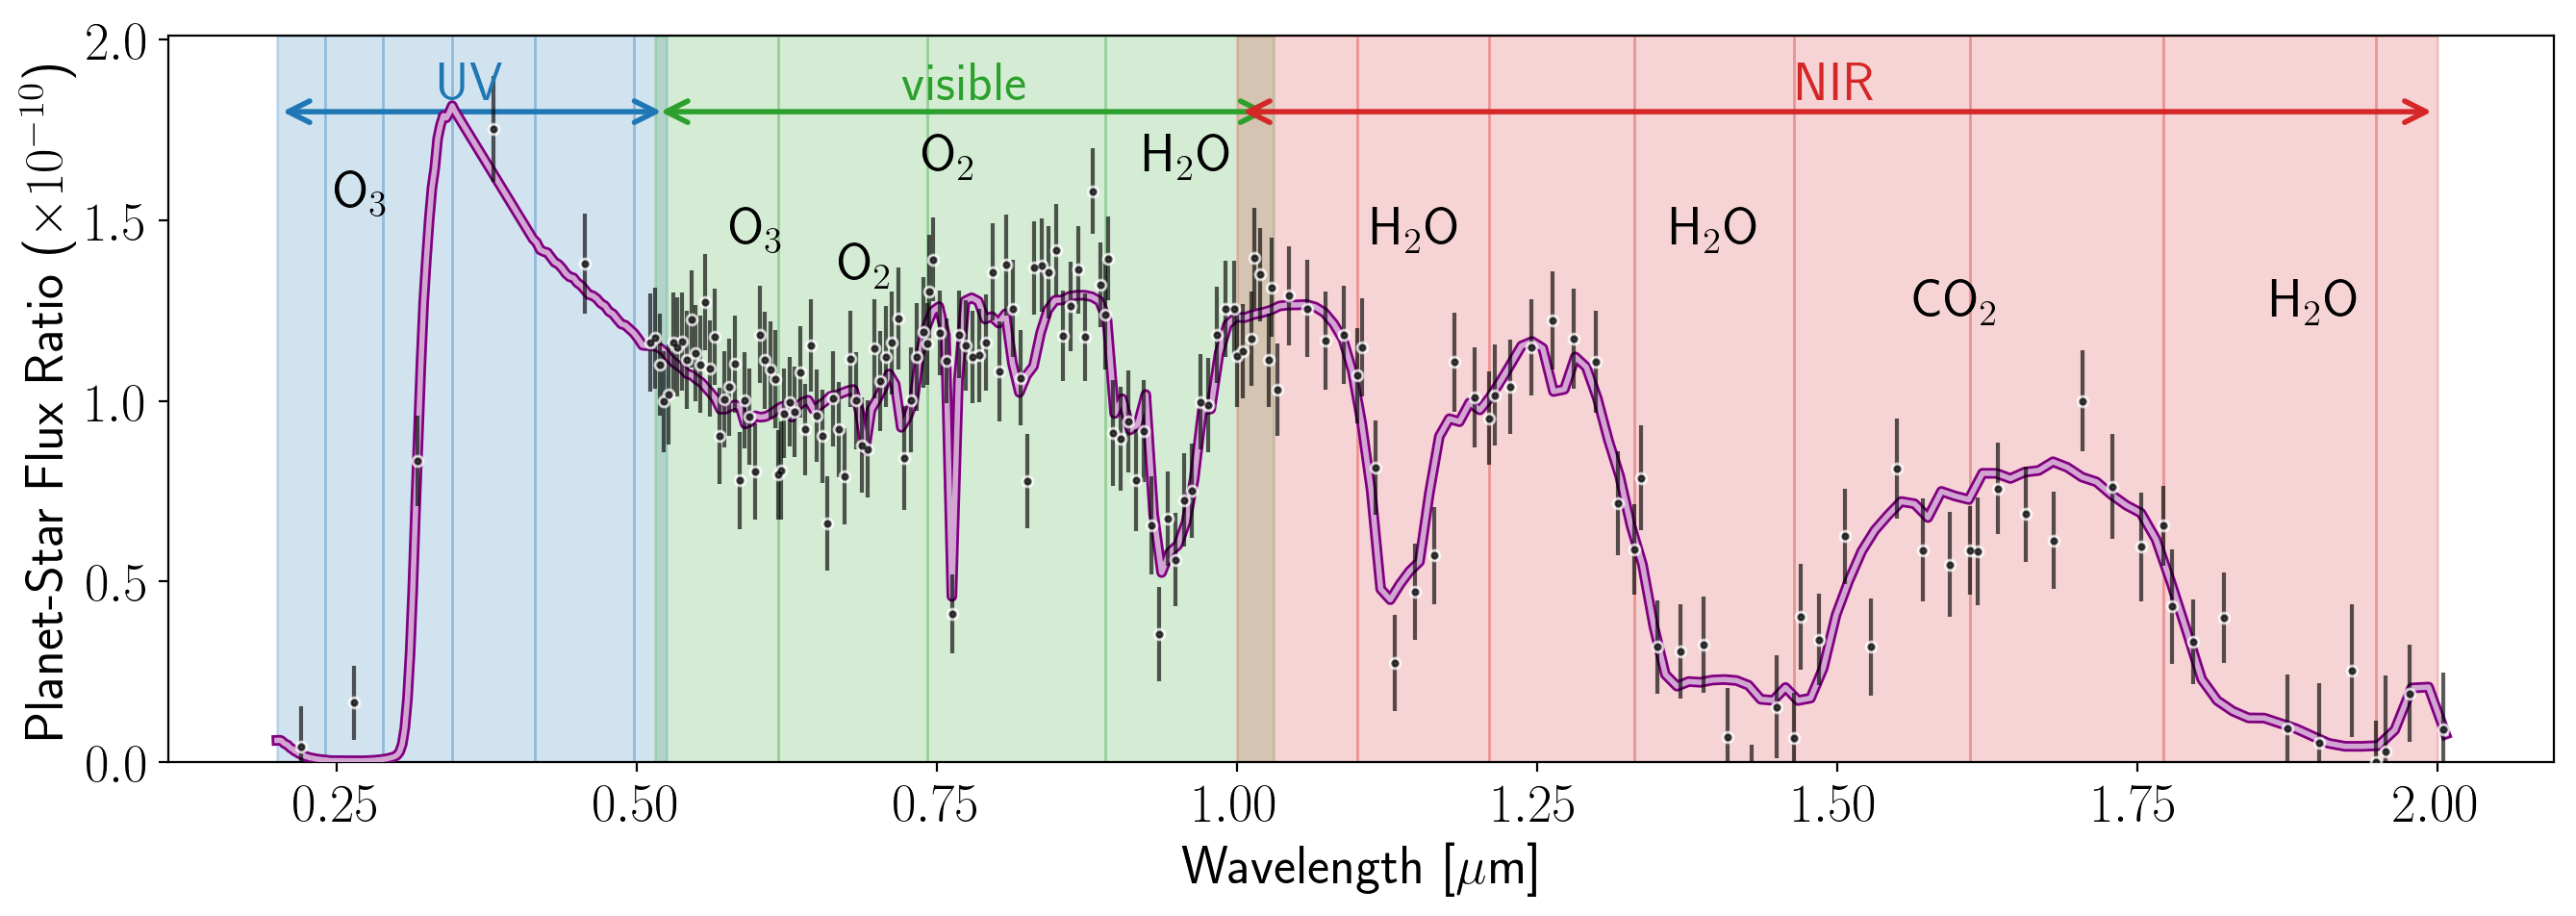

In [7]:
fig, ax = drmx.plot_observed_spectrum()

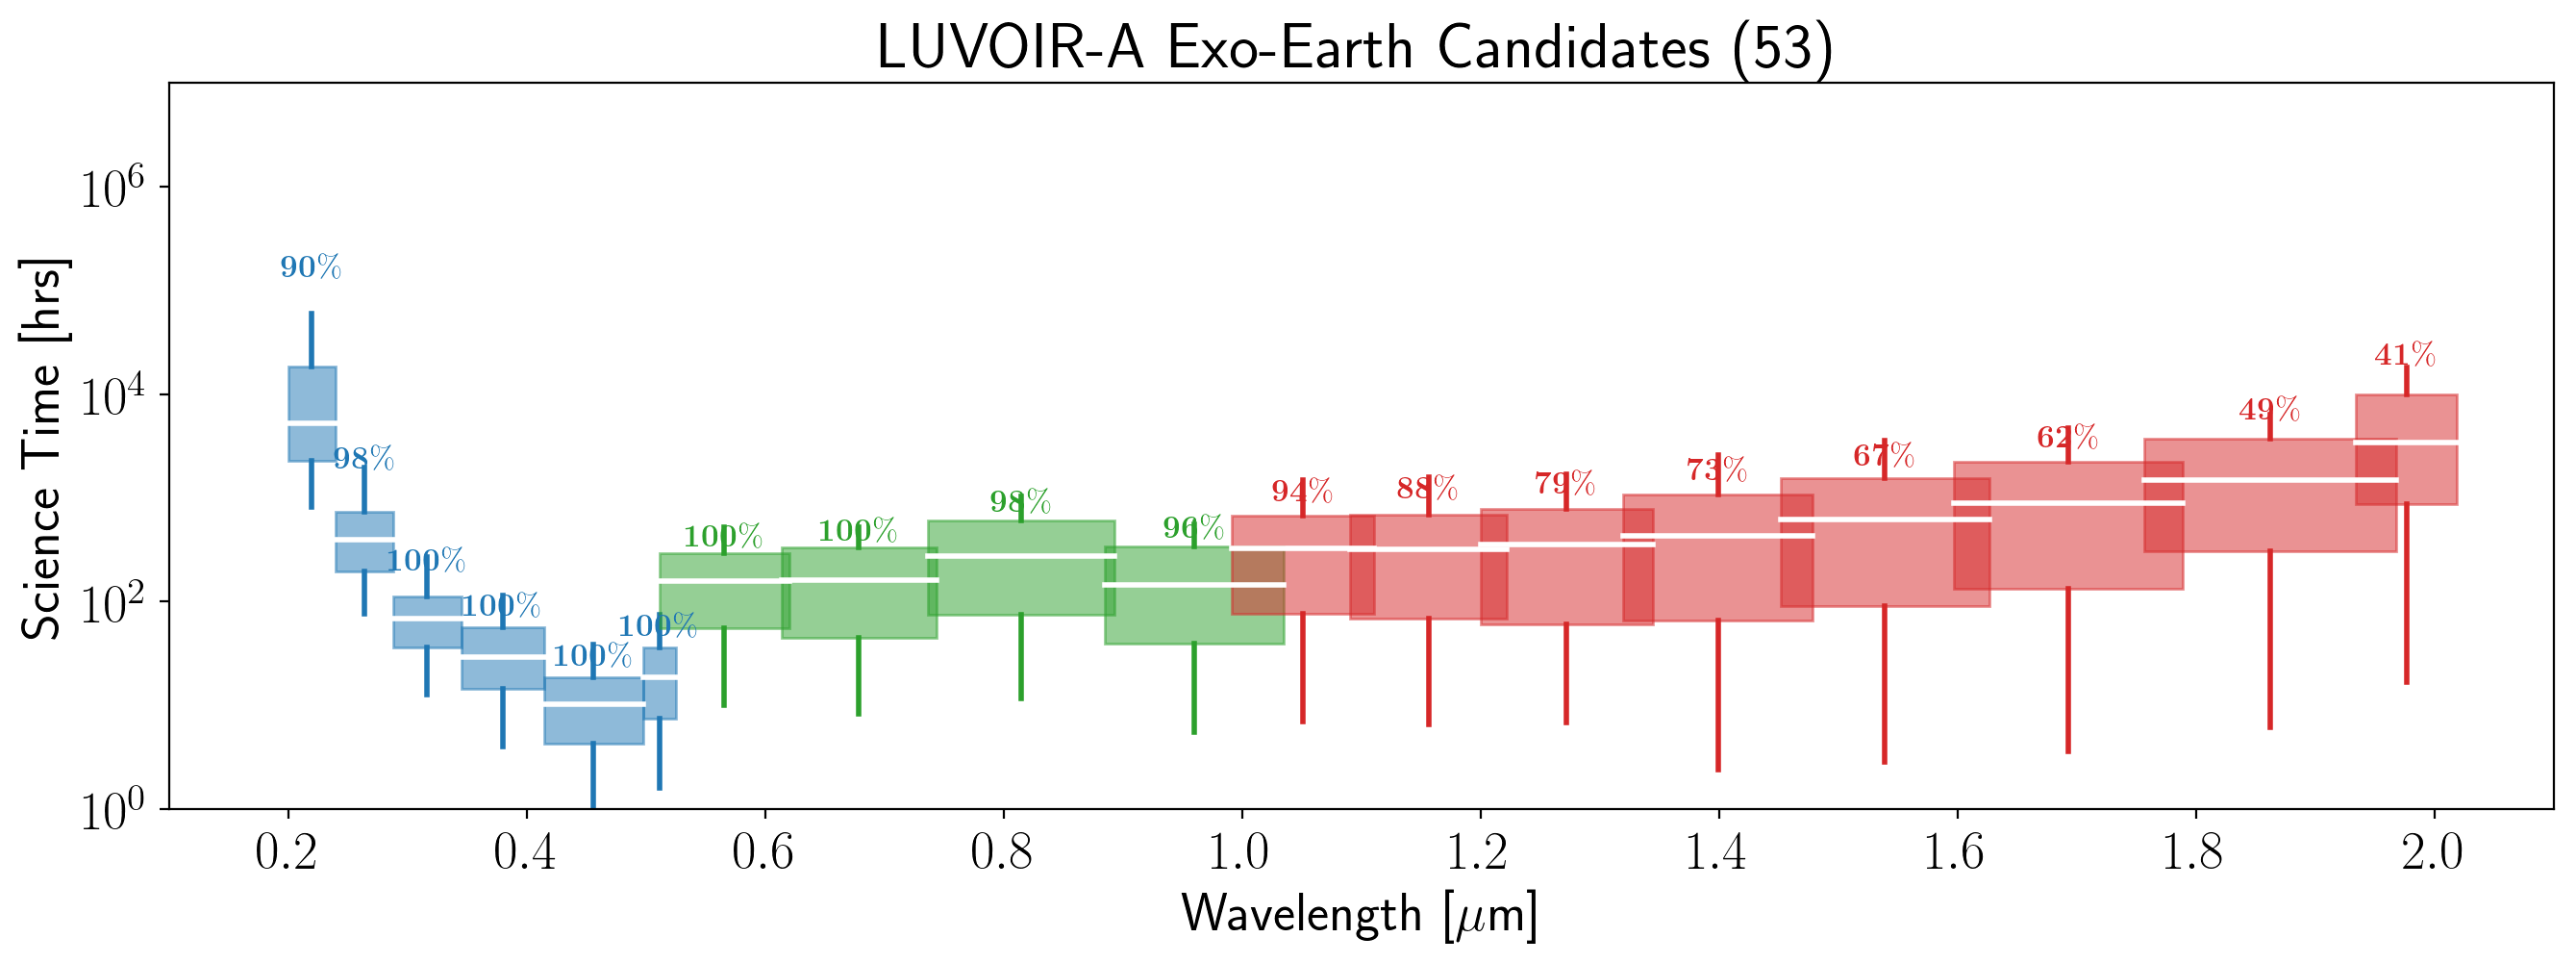

In [8]:
fig = drmx.plot_bp_exptimes(plot_spectrum = False, title = "LUVOIR-A Exo-Earth Candidates (%i)" %drmx.NBIAS)

Text(0,1,'Total Exposure Time (days)')

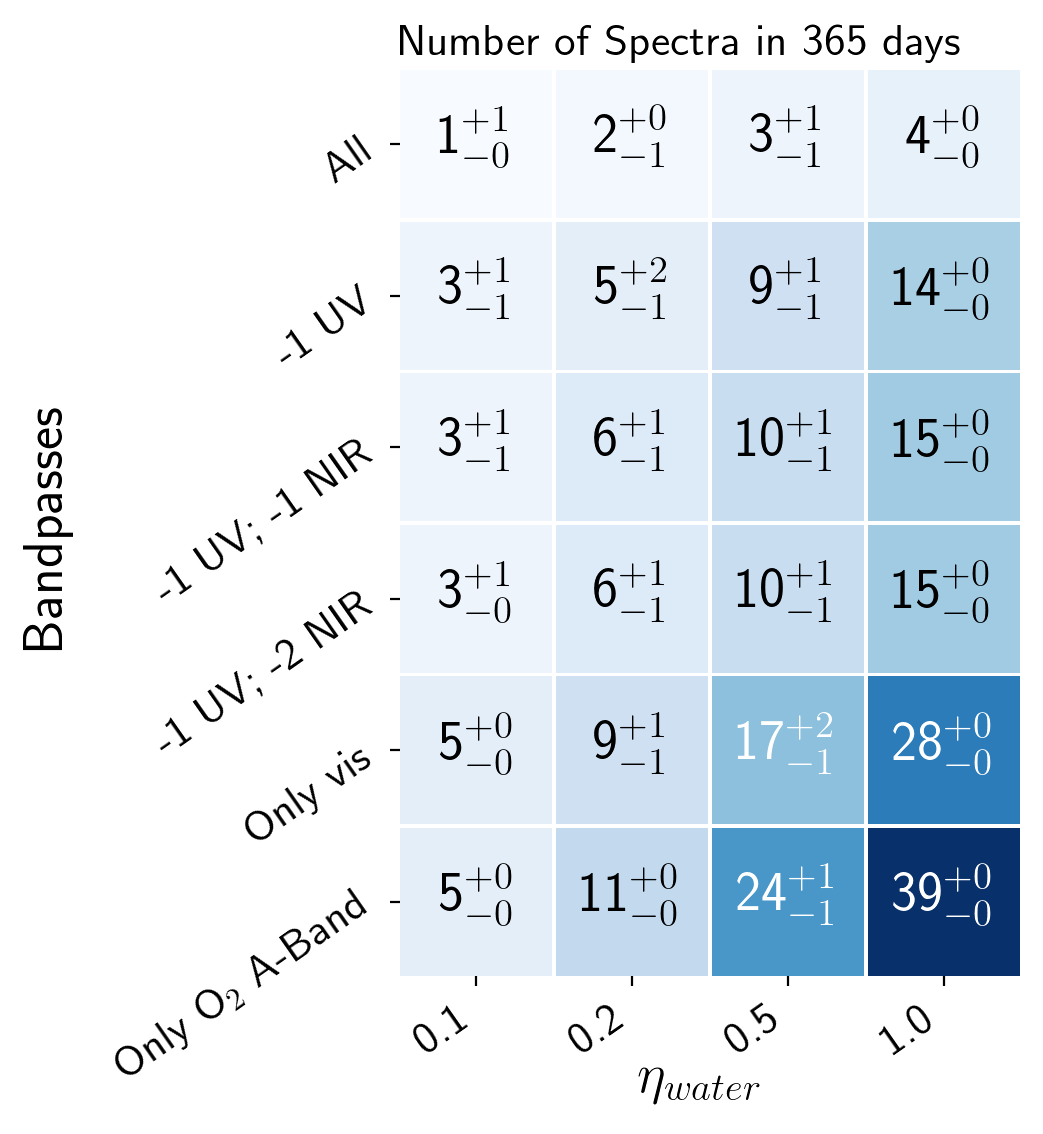

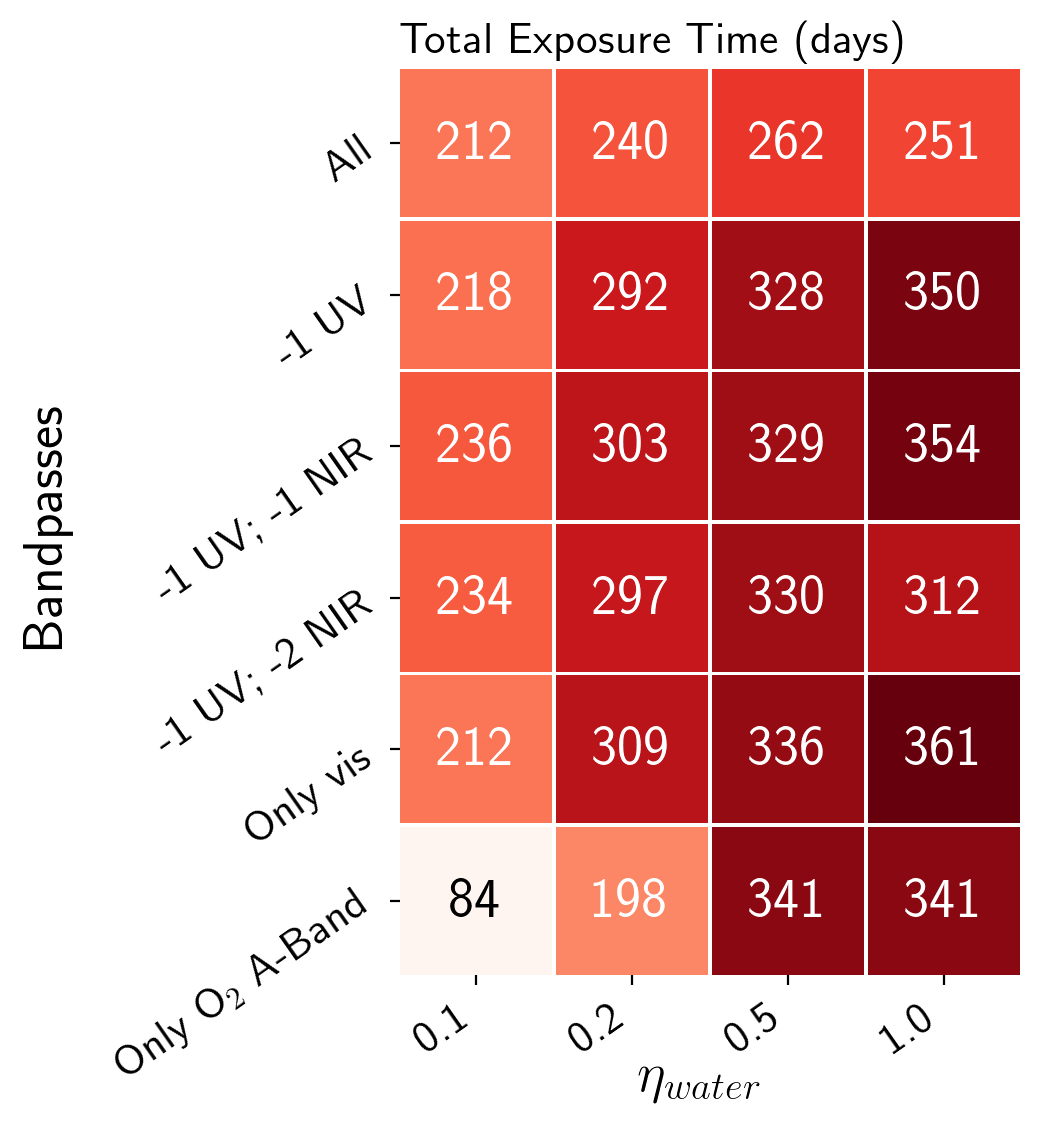

In [9]:
# Define cases 
ibp = np.arange(len(drmx.bp_names))
case_names = [
    "All", 
    "-1 UV", 
    "-1 UV; -1 NIR", 
    "-1 UV; -2 NIR", 
    "Only vis",
    r"Only O$_2$ A-Band"
]
cases = [
    spectroscopy.get_iremove(drmx, Nremove_uv=0, Nremove_nir=0), 
    spectroscopy.get_iremove(drmx, Nremove_uv=1, Nremove_nir=0), 
    spectroscopy.get_iremove(drmx, Nremove_uv=1, Nremove_nir=1), 
    spectroscopy.get_iremove(drmx, Nremove_uv=1, Nremove_nir=2), 
    ibp[(drmx.bp_chan == 0) | (drmx.bp_chan == 2)],
    ibp[(drmx.bandpasses[:,0] > 0.76) | (drmx.bandpasses[:,1] < 0.76)]
]

# Define eta range
Xdraw = 500
etas = np.array([0.1, 0.2, 0.5, 1.0])
Ndraws = np.array(np.round(etas*drmx.NBIAS), dtype=int)

# Run DRM for Xdraw number of times
t_totx = np.zeros((len(Ndraws), len(cases), 3))
t_scix = np.zeros((len(Ndraws), len(cases), 3))
t_ovrx = np.zeros((len(Ndraws), len(cases), 3))
countx = np.zeros((len(Ndraws), len(cases), 3))
for i in range(len(Ndraws)):
    for j in range(len(cases)):
        t_tmp = np.zeros(Xdraw)
        t_sci = np.zeros(Xdraw)
        t_ovr = np.zeros(Xdraw)
        c_tmp = np.zeros(Xdraw)
        for x in range(Xdraw):
            t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = drmx.run_hec_drm(Ndraw = Ndraws[i], 
                                                                                                           verbose = False, 
                                                                                                           iremove = cases[j], 
                                                                                                           wantexp_days=drmx.wantexp)
            t_tmp[x] = np.sum(t_tot_sort[:count_in_texp]) / 24.
            t_sci[x] = np.sum(t_sci_sort[:count_in_texp]) / 24.
            t_ovr[x] = np.sum(t_ovr_sort[:count_in_texp]) / 24.
            c_tmp[x] = count_in_texp
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_tmp)
        t_totx[i,j,0], t_totx[i,j,1], t_totx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_sci)
        t_scix[i,j,0], t_scix[i,j,1], t_scix[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(t_ovr)
        t_ovrx[i,j,0], t_ovrx[i,j,1], t_ovrx[i,j,2] = q_50, q_p, q_m
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(c_tmp)
        countx[i,j,0], countx[i,j,1], countx[i,j,2] = q_50, q_p, q_m

# Make Table of results
fig, ax = ColorTable(etas, case_names, countx[:,:,0], fmt = "%i", data_pm = (countx[:,:,1], countx[:,:,2]), labelfontsize=16, labelrotation=35, 
                     ylabel = "Bandpasses", xlabel = r"$\eta_{water}$", ylabel_spacing=-0.35, xlabel_spacing = 0.01)
ax[0,0].set_title("Number of Spectra in %i days" %drmx.wantexp, ha = "left", fontsize = 16, loc = "left")

fig, ax = ColorTable(etas, case_names, t_totx[:,:,0], fmt = "%i", labelfontsize=16, labelrotation=35, colormap = "Reds",
                     ylabel = "Bandpasses", xlabel = r"$\eta_{water}$", ylabel_spacing=-0.35, xlabel_spacing = 0.01, textsize = 16)
                     #data_pm = (t_totx[:,:,1], t_totx[:,:,2]))
ax[0,0].set_title("Total Exposure Time (days)", ha = "left", fontsize = 16, loc = "left")

In [10]:
icase = 3

iremove = cases[icase]
iname = case_names[icase]

Xdraw = 200
Ndraws = np.arange(1,drmx.NBIAS)
wantdays = np.linspace(5, 365*2, 20)

zcube = np.zeros((len(Ndraws), len(wantdays), Xdraw))

np.random.seed(seed = None)

for i in range(len(Ndraws)):
    for j in range(len(wantdays)):
        for k in range(Xdraw):
            t_tot_sort, count_in_texp, c_tot_sort, tpbpcs_draws, t_sci_sort, t_ovr_sort = drmx.run_hec_drm(Ndraw = Ndraws[i], wantexp_days = wantdays[j], verbose = False, iremove = iremove) 
            zcube[i,j,k] = count_in_texp
            
zmean = np.mean(zcube, axis = 2)

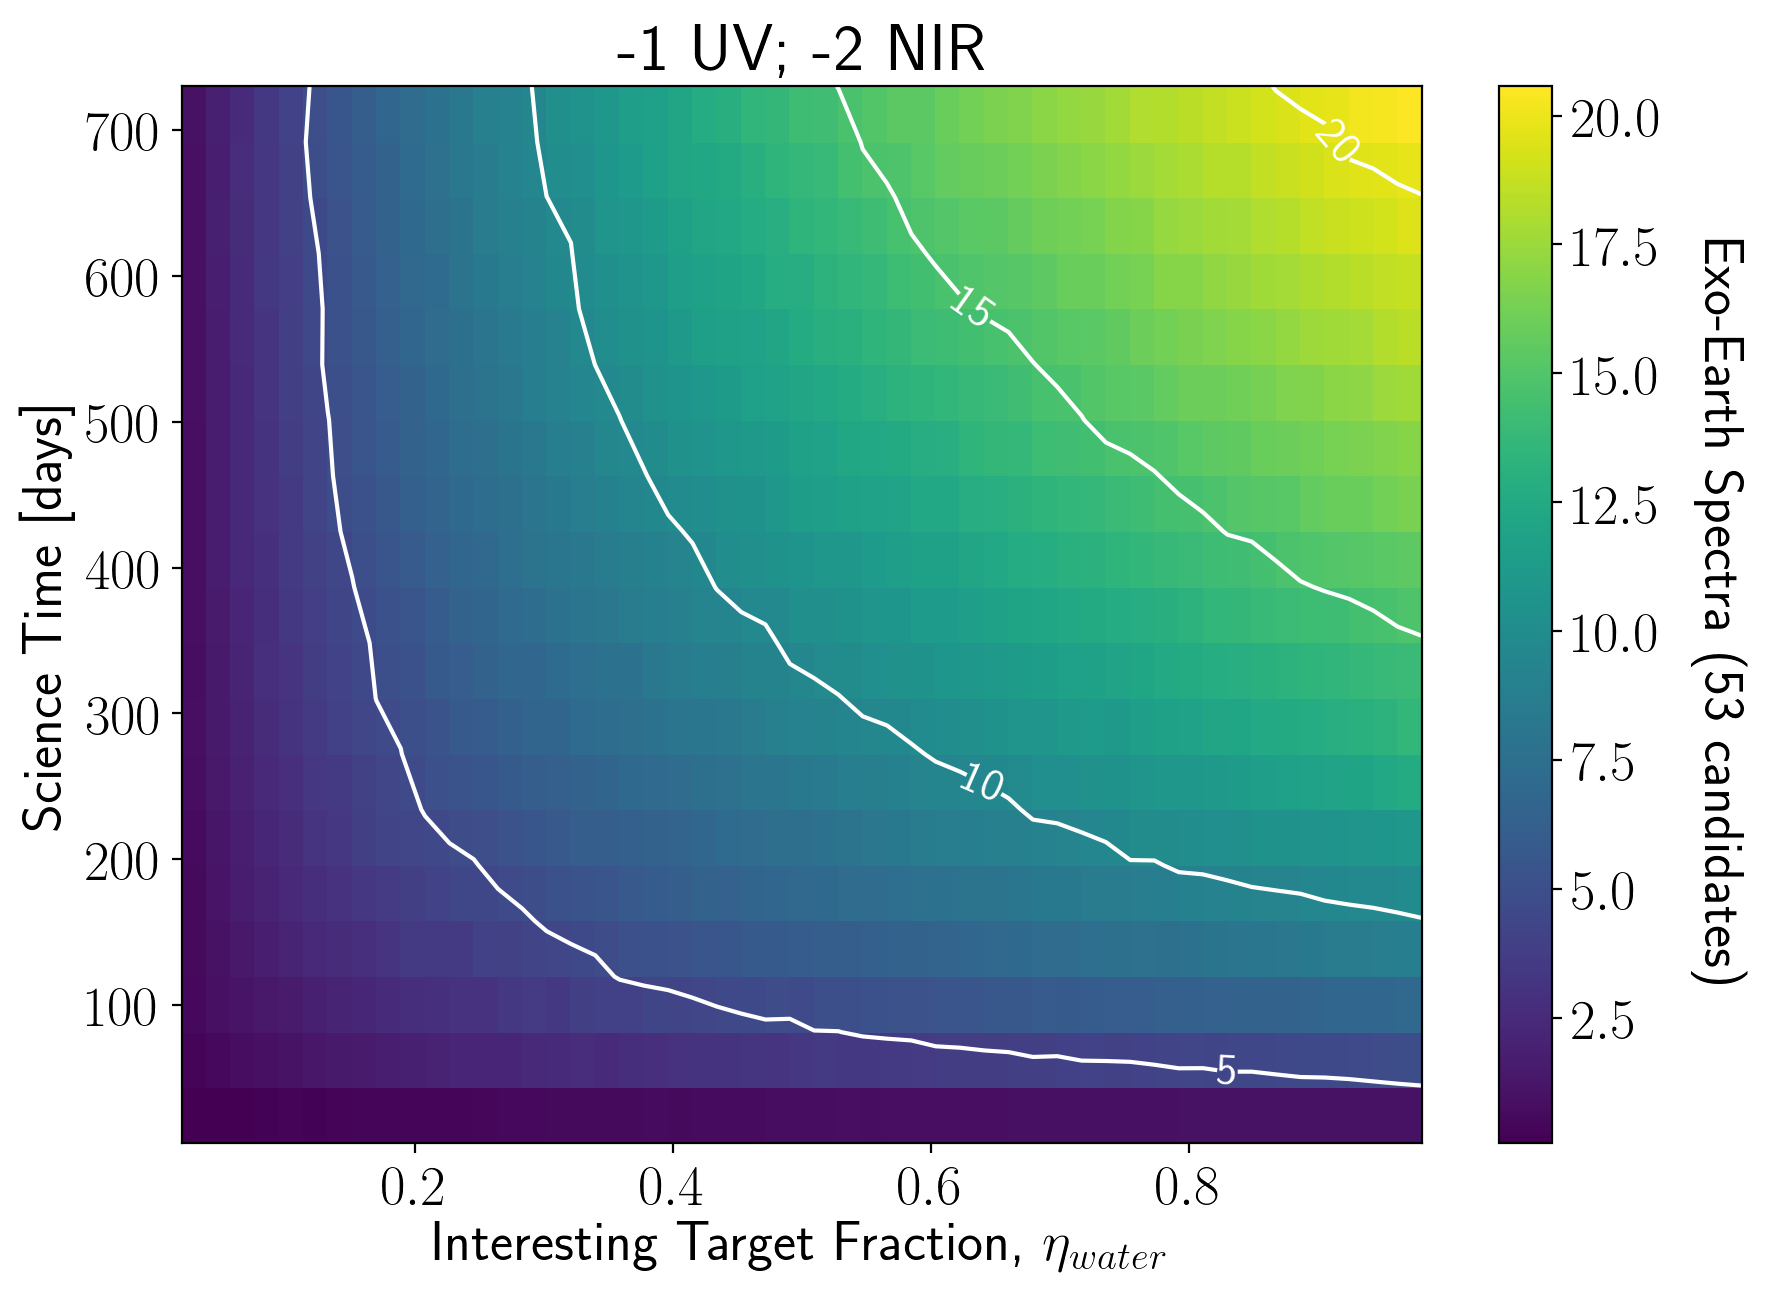

In [13]:
contour_intervals = 5.0
levels = list(np.arange(1, zmean.max() / contour_intervals) * contour_intervals)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("%i total stars in sample" %drmx.NBIAS)
#ax.set_title("%i\%%; %s" %(100*drmx.bandwidth, iname))
ax.set_title("%s" %(iname))
ax.set_xlabel("Interesting Target Fraction, $\eta_{water}$")
ax.set_ylabel("Science Time [days]")
p = ax.pcolor(Ndraws / float(drmx.NBIAS), wantdays, zmean.T)
cln = ax.contour(Ndraws / float(drmx.NBIAS), wantdays, zmean.T, colors="w", levels = levels)
plt.clabel(cln, inline=1, fontsize=16, inline_spacing=1, fmt = "%i", rightside_up = True)
cbar = fig.colorbar(p)
cbar.set_label("Exo-Earth Spectra (%i candidates)" %drmx.NBIAS, rotation = 270, labelpad = 30)
p.set_rasterized(True)
#fig.savefig("/Users/Jake/Dropbox/Astronomy/UW/Astrobio/Research Rotation/LUVOIR/figures/drm_arch%s_time_vs_eta_case4.pdf" %architecture, bbox_inches = "tight")

"""
zstd = np.std(zcube, axis = 2)

fig, ax = plt.subplots()
ax.set_title("%i total stars in sample" %drmx.NBIAS)
ax.set_xlabel("Interesting Target Fraction, $\eta_{water}$")
ax.set_ylabel("Observing Time [days]")
p = ax.pcolor(Ndraws / float(drmx.NBIAS), wantdays, zstd.T)
fig.colorbar(p, label = "Std Num of Complete Spectra")
""";